# Modeling corona virus in Germany

Fit a very simple infection model and compare it to the current numbers of Germany.

First run `git clone https://github.com/CSSEGISandData/COVID-19.git && cd COVID-19`

In [1]:
!date

Mo 9. Mär 00:14:05 CET 2020


<div class="alert alert-block alert-info"><b>Note:</b> This uses a very simple model (SIR model). The model's recovery rate is set to 1/14 (2 weeks average). The model assumes fixed R0. R0 could be overestimated if the increase in numbers of infected is not primarily due to more infected but to more tests. Of course, R0 will decrease if appropriate measures are taken.</div>

## imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%pylab inline

from itertools import chain

import numpy as np
from scipy.integrate import odeint
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## parameters

### plotting

In [3]:
plt.style.use('seaborn')
FS = 16  # font size

### modeling

According to this paper, R0, the basic reproduction number, is between 4.7 and 6.6: https://www.medrxiv.org/content/10.1101/2020.02.07.20021154v1.full.pdf

Assuming that 0.5% of infected people die

In [4]:
R0_u = 6.6                # upper limit R0
R0_l = 4.7                # lower limit R0
gamma = 1. / 14           # mean recovery rate
beta_u = R0_u * gamma     # contact or infection rate
beta_l = R0_l * gamma     # contact or infection rate
death = 0.005 * gamma     # mortality rate
N = 80000000              # total population

include_mortality = False # whether to include virus induced mortality to the model

## load current data

In [5]:
def load_data(path, country='Germany'):
    df = pd.read_csv(path)
    df = df.rename(columns={'Country/Region': 'country'})
    df = df.query(f'country=={country!r}')
    df.index = ['cases']
    df = df.T.tail(-4).reset_index()  # drop non-case values like lat and long
    df = df.assign(date=pd.to_datetime(df['index']))
    return df

In [6]:
!git pull origin master

From https://github.com/CSSEGISandData/COVID-19
 * branch            master     -> FETCH_HEAD
Already up to date.


In [7]:
df = load_data('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [8]:
dfd = load_data('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

In [9]:
dfr = load_data('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

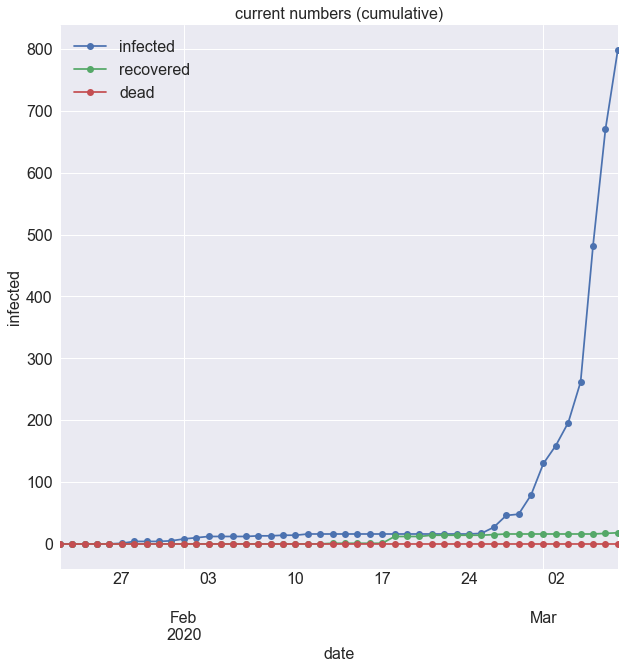

In [10]:
ax = df.plot(x='date', y='cases', figsize=(10, 10), fontsize=FS, marker='o', label='infected')
ax = dfr.plot(x='date', y='cases', figsize=(10, 10), fontsize=FS, marker='o', label='recovered', ax=ax)
ax = dfd.plot(x='date', y='cases', figsize=(10, 10), fontsize=FS, marker='o', label='dead', ax=ax)
ax.set_xlabel('date', fontsize=FS)
ax.set_ylabel('infected', fontsize=FS)
ax.legend(fontsize=FS)
ax.set_title('current numbers (cumulative)', fontsize=FS);

## model

Simple SIR model, see: https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease

Model code from here: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [11]:
# Initial number of infected and recovered individuals, inf0 and rec0.
inf0, rec0, dead0 = 1, 0, 0
# Everyone else, sus0, is susceptible to infection initially.
sus0 = N - inf0 - rec0 - dead0
# A grid of time points (in days)
t = np.arange(200)

In [12]:
# The SIR model differential equations.
def deriv_without_mortality(y, t, N, beta, gamma):
    """
    * S: susceptible
    * I: infected
    * R: recovered
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [13]:
# with mortality
def deriv_with_mortality(y, t, N, beta, gamma, death):
    """
    * S: susceptible
    * I: infected
    * R: recovered
    * D: deaths
    """
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + death) * I
    dRdt = gamma * I
    dDdt = death * I
    return dSdt, dIdt, dRdt, dDdt

In [14]:
deriv = deriv_with_mortality if include_mortality else deriv_without_mortality

In [15]:
if include_mortality:
    y0 = sus0, inf0, rec0, dead0
    # lower limit
    ret = odeint(deriv, y0, t, args=(N, beta_l, gamma, death))
    S, I, R, D = ret.T
    # upper limit
    ret = odeint(deriv, y0, t, args=(N, beta_u, gamma, death))
    S_u, I_u, R_u, D_u = ret.T
else:
    y0 = sus0, inf0, rec0
    # lower limit
    ret = odeint(deriv, y0, t, args=(N, beta_l, gamma))
    S, I, R = ret.T
    # upper limit
    ret = odeint(deriv, y0, t, args=(N, beta_u, gamma))
    S_u, I_u, R_u = ret.T

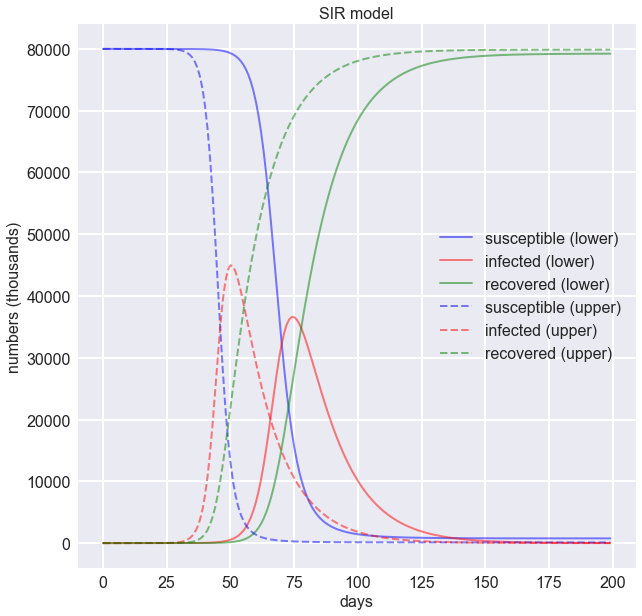

In [16]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='susceptible (lower)')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='infected (lower)')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='recovered (lower)')
if include_mortality:
    ax.plot(t, D/1000, 'k', alpha=0.5, lw=2, label='dead (lower)')
ax.plot(t, S_u/1000, 'b', alpha=0.5, lw=2, ls='--', label='susceptible (upper)')
ax.plot(t, I_u/1000, 'r', alpha=0.5, lw=2, ls='--', label='infected (upper)')
ax.plot(t, R_u/1000, 'g', alpha=0.5, lw=2, ls='--', label='recovered (upper)')
if include_mortality:
    ax.plot(t, D_u/1000, 'k--', alpha=0.5, lw=2, label='dead (upper)')

ax.set_xlabel('days', fontsize=FS)
ax.set_ylabel('numbers (thousands)', fontsize=FS)
ax.set_title('SIR model', fontsize=FS)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize=FS)
legend.get_frame().set_alpha(0.5)
for tick in chain(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
    tick.label.set_fontsize(FS)

## comparison

### "fit" real and model

In [17]:
def mse(x, y):
    return ((np.array(x) - np.array(y)) ** 2).mean()

In [18]:
def calculate_offset(real, model, metric=mse):
    """'Fit' the model to the data be calculating best offset

    Move data from left to right to find the point at which
    the MSLE is minimized. Effectively, it is assumed that
    the onset of the outbreak is a free variable.

    This could be considered "fitting" the model to the data.

    """
    m = len(real)
    n = len(model)
    assert n > 2 * m

    offsets = []
    for i in range(m):
        real_subset = real[i:]
        model_subset = model[:len(real_subset)]
        error = metric(real_subset, model_subset)
        offsets.append((i, error))

    return min(offsets, key=lambda tup: tup[1])[0]

In [19]:
offset = calculate_offset(df['cases'].astype(float), I)
offset_u = calculate_offset(df['cases'].astype(float), I_u)
print(f"calculated offset: {offset} (lower), {offset_u} (upper)")

calculated offset: 20 (lower), 28 (upper)


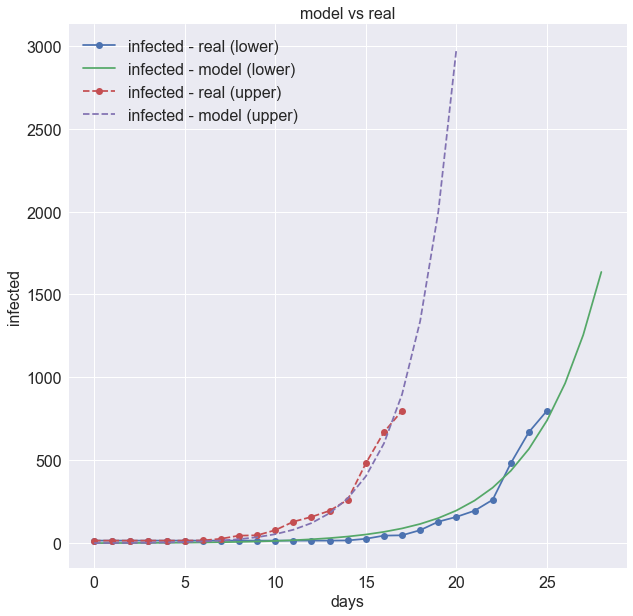

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

cases = df['cases'][offset:].values
ax.plot(cases, marker='o', label='infected - real (lower)')
ax.plot(I[:len(cases) + 3], label='infected - model (lower)')
if include_mortality:
    ax.plot(D[:len(cases) + 3], label='dead - model (lower)')

cases_u = df['cases'][offset_u:].values
ax.plot(cases_u, marker='o', label='infected - real (upper)', ls='--')
ax.plot(I_u[:len(cases_u) + 3], label='infected - model (upper)', ls='--')
if include_mortality:
    ax.plot(D_u[:len(cases_u) + 3], label='dead - model (upper)', ls='--')

ax.legend(fontsize=FS)
ax.set_xlabel('days', fontsize=FS)
ax.set_ylabel('infected', fontsize=FS)
ax.set_title('model vs real', fontsize=FS)
for tick in chain(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
    tick.label.set_fontsize(FS)

### project numbers

In [21]:
current = df['cases'].values[-1]
print("current number of infected: {}".format(current))

current number of infected: 799


In [22]:
# where are we now in the model?
idx = np.argmin(abs(I - current))
idx_u = np.argmin(abs(I_u - current))

In [23]:
print("lower estimate")
print("maximum number of infected: {}, reached in {} days".format(
    int(max(I)), np.argmax(I) - idx))
if include_mortality:
    print("total deaths: {}".format(int(D[-1])))
print()

print("upper estimate")
print("maximum number of infected: {}, reached in {} days".format(
    int(max(I_u)), np.argmax(I_u) - idx_u))
if include_mortality:
    print("total deaths: {}".format(int(D_u[-1])))

lower estimate
maximum number of infected: 36597787, reached in 49 days

upper estimate
maximum number of infected: 44972432, reached in 33 days


In [24]:
print("21 days projection", end="\n\n")
sl = slice(idx - 1, idx + 22)
sl_u = slice(idx_u - 1, idx_u + 22)

if include_mortality:
    print("day   infected (lower)  dead (lower)  infected (upper)  dead (upper)")
    for i, (infected, dead, infected_u, dead_u) in enumerate(zip(I[sl], D[sl], I_u[sl_u], D_u[sl_u]), start=-1):
        print(f" {i:>2} {int(infected): >18}  {int(dead): >12}  ", end="")
        print(f"{int(infected_u): >16} {int(dead_u): >13}")
else:
    print("day   infected (lower)  infected (upper)")
    for i, (infected, infected_u) in enumerate(zip(I[sl], I_u[sl_u]), start=-1):
        print(f" {i:>2} {int(infected): >18}  {int(infected_u): >16}  ")

21 days projection

day   infected (lower)  infected (upper)
 -1                568               601  
  0                740               897  
  1                964              1339  
  2               1256              1998  
  3               1635              2980  
  4               2130              4446  
  5               2775              6633  
  6               3614              9895  
  7               4708             14761  
  8               6132             22018  
  9               7986             32840  
 10              10402             48979  
 11              13548             73037  
 12              17645            108891  
 13              22980            162296  
 14              29927            241782  
 15              38973            359953  
 16              50751            535340  
 17              66082            794996  
 18              86038           1177988  
 19             112006           1739815  
 20             145788           255